# Analysing the air pollution levels of Barcelona during the COVID-19 pandemic lockdowns
#### *Social Data Analysis and Visualization*  
*Daniel Ansia Dibuja, Eduard Seguí Solé, Zhijian Feng*

### Imports

In [171]:
# Generic Imports & settings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt, dates as mdates
import plotly.graph_objs as go
import plotly.io as pio
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib
import datetime as dt
import seaborn as sns
import plotly.express as px


matplotlib.style.use('seaborn-whitegrid')
pio.templates.default = "plotly_white"

## 1. Motivation

The datasets we used for this project are three different ones:

- Data on air pollution in the city of Barcelona between 2019 and 2022 (period of data availability) obtained from the City Council containing information per hour on NO2, PM10, PM2.5 and O3 concentration levels for 7 different stations spread accross the city and categorised as "traffic" and "background" stations.
- Data on meteorological conditions in Barcelona during the same period of time. Since meteorological conditions are one of the most influencing factors for air quality, they are essential in our research.
- Data on restrictions imposed: containing the most impactful rules in terms of mobility and their periods of applications. We could not find this data online so we generated it ourselves manually.

We chose these datasets because they contain the data that we needed to perform our analysis. We want to analyse the effect of restriction rules on air pollution, hence they seemed like the natural choices to make. We could not find data on mobility, which we believe limited us in our work.

Our final goal was to create a story that the reader can relate to, find useful information from, and especially interact with in order to understand air pollution in Barcelona and try to find out which rules were the most impactful ones for the reduction of pollution.

## 2. Basic Stats

#### Air pollution data

The data ranges from May 2019 until April 2022. This period is the only one where data was available. In order to clean and merge all the datasets (there were 1 per month where the rows where the hours of the day and the columns were the days of the month) we had to use metaprogramming in order to be able to merge the dataset and create a clean time series.

The datasets contained data for 8 stations in the city and for several pollutants. The rows corresponded to days of the month and pollutant and the columns were the hour of the day plus validation of each measurement. All values are in micrograms/cubic metre, which is the standard measuring unit.

Station 8 was removed from the visualization and analysis due to it only being operational after 2020.

In [172]:
df = pd.read_csv('barcelona.csv')
df.drop(['CODI_PROVINCIA', 'PROVINCIA', 'CODI_MUNICIPI', 'MUNICIPI',
         'V01', 'V02', 'V03', 'V04', 'V05', 'V06', 'V07', 'V08', 'V09', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15',
         'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24'], axis=1, inplace=True)
df.rename(columns={'CODI_CONTAMINANT': 'pollutant',
                   'ESTACIO': 'station'}, inplace=True)
df.loc[df['pollutant'] == '7']
df['DIA'] = df['DIA'].str.zfill(2)
df['MES'] = df['MES'].str.zfill(2)

In [173]:
# Turn column H01 into a row that keeps the ANY, MES, DIA values
#df['H01'] = df['H01'].apply(lambda x: x[0])

df.drop(df[df['ANY'] == 'ANY'].index, axis=0, inplace=True)
df.drop(df[df['MES'] == 'MES'].index, axis=0, inplace=True)
df.drop(df[df['DIA'] == 'DIA'].index, axis=0, inplace=True)


# Combine the columns 'ANY', 'MES', 'DIA' into a single datetime column
df['date'] = df[['ANY', 'MES', 'DIA']].apply(lambda x: '-'.join(x), axis=1)
#df['date'] = df['date'].astype(str)
#df.head()
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df = df[['date', 'station', 'pollutant', 'H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H08', 'H09',
         'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'H24']]


In [174]:
# We use meta-programming to create 24 dataframes, one for each hour of the day.
for i in range(1, 25):
    j = str(i).zfill(2)
    exec(f"H{j} = df[['date', 'station', 'pollutant','H{j}']]")

    # We change the date to datetime adding the hour connected to the column
    exec(f"H{j}['date'] = pd.to_datetime(H{j}['date'], format='%Y-%m-%d') + pd.to_timedelta(int({i}), unit='h')")

    # 24 dataframes for each hour of the day for NO2.
    exec(f"NO2_H{j} = H{j}.loc[H{j}['pollutant'] == '8']")
    exec(f"NO2_H{j} = NO2_H{j}.pivot(index='date', columns='station', values='H{j}')")

    # 24 dataframes for each hour of the day for PM10.
    exec(f"PM10_H{j} = H{j}.loc[H{j}['pollutant'] == '10']")
    exec(f"PM10_H{j} = PM10_H{j}.pivot(index='date', columns='station', values='H{j}')")

    # 24 dataframes for each hour of the day for PM2.5.
    exec(f"PM25_H{j} = H{j}.loc[H{j}['pollutant'] == '9']")
    exec(f"PM25_H{j} = PM25_H{j}.pivot(index='date', columns='station', values='H{j}')")

# combine dataframes based on their index value
NO2 = pd.concat([NO2_H01, NO2_H02, NO2_H03, NO2_H04, NO2_H05, NO2_H06, NO2_H07, NO2_H08, NO2_H09, NO2_H10, NO2_H11, NO2_H12,
                 NO2_H13, NO2_H14, NO2_H15, NO2_H16, NO2_H17, NO2_H18, NO2_H19, NO2_H20, NO2_H21, NO2_H22, NO2_H23, NO2_H24], axis=0)
NO2.sort_index(inplace=True)
# concat PM10 dataframes
PM10 = pd.concat([PM10_H01, PM10_H02, PM10_H03, PM10_H04, PM10_H05, PM10_H06, PM10_H07, PM10_H08, PM10_H09, PM10_H10, PM10_H11, PM10_H12,
                  PM10_H13, PM10_H14, PM10_H15, PM10_H16, PM10_H17, PM10_H18, PM10_H19, PM10_H20, PM10_H21, PM10_H22, PM10_H23, PM10_H24], axis=0)
PM10.sort_index(inplace=True)
# concat PM2.5 dataframes
PM25 = pd.concat([PM25_H01, PM25_H02, PM25_H03, PM25_H04, PM25_H05, PM25_H06, PM25_H07, PM25_H08, PM25_H09, PM25_H10, PM25_H11, PM25_H12,
                  PM25_H13, PM25_H14, PM25_H15, PM25_H16, PM25_H17, PM25_H18, PM25_H19, PM25_H20, PM25_H21, PM25_H22, PM25_H23, PM25_H24], axis=0)
PM25.sort_index(inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [175]:
NO2 = NO2.astype(float)
PM10 = PM10.astype(float)
PM25 = PM25.astype(float)

NO2.to_csv('NO2.csv')
PM10.to_csv('PM10.csv')
PM25.to_csv('PM25.csv')

We have finally generated different CSV files containing time series for each pollutant. Even though later on we decided to mainly focus our article on NO2, we created visualizations for the most important pollutants (NO2, PM10, PM25).

<AxesSubplot:title={'center':'NO2 pollution in April 2019 at station 4'}, xlabel='date', ylabel='NO2 (μg/m3)'>

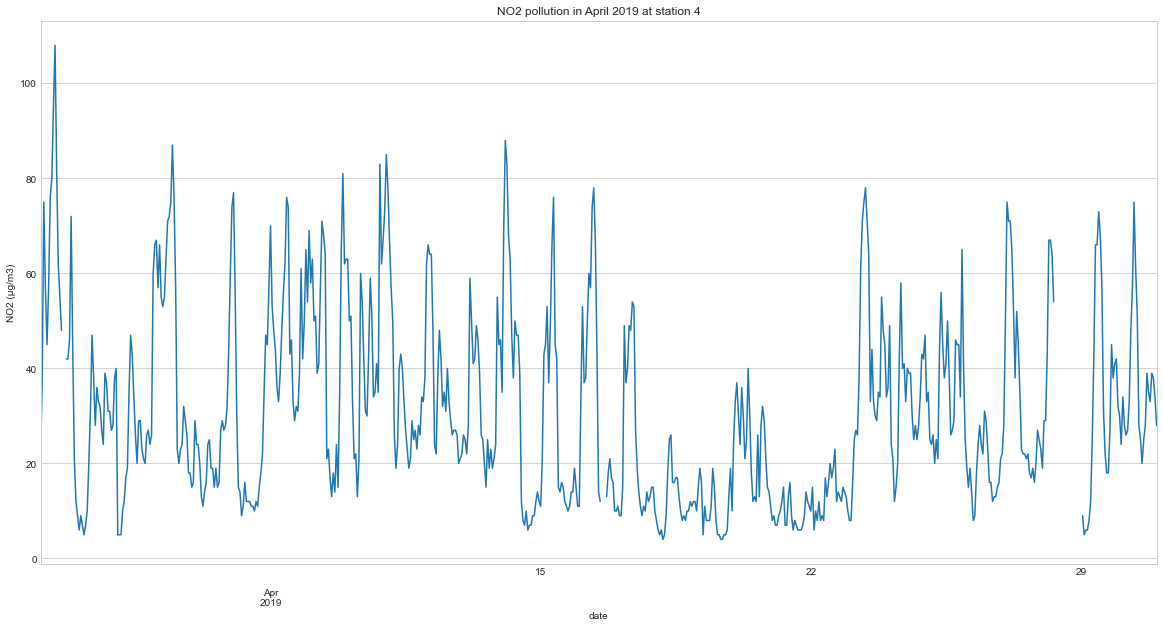

In [176]:
NO2['4'].loc['2019-04':'2019-04'].plot(figsize=(
    20, 10), title='NO2 pollution in April 2019 at station 4', ylabel='NO2 (μg/m3)')


In the previous plot we can see huge variations of concentration levels. Air pollution tends to be very quick to change depending on the meteorological and other conditions, therefore every hour there are different numbers, as we can see in the following plot of a specific day.

<AxesSubplot:title={'center':'NO2 pollution in April 13, 2019 at station 43'}, xlabel='date', ylabel='NO2 (μg/m3)'>

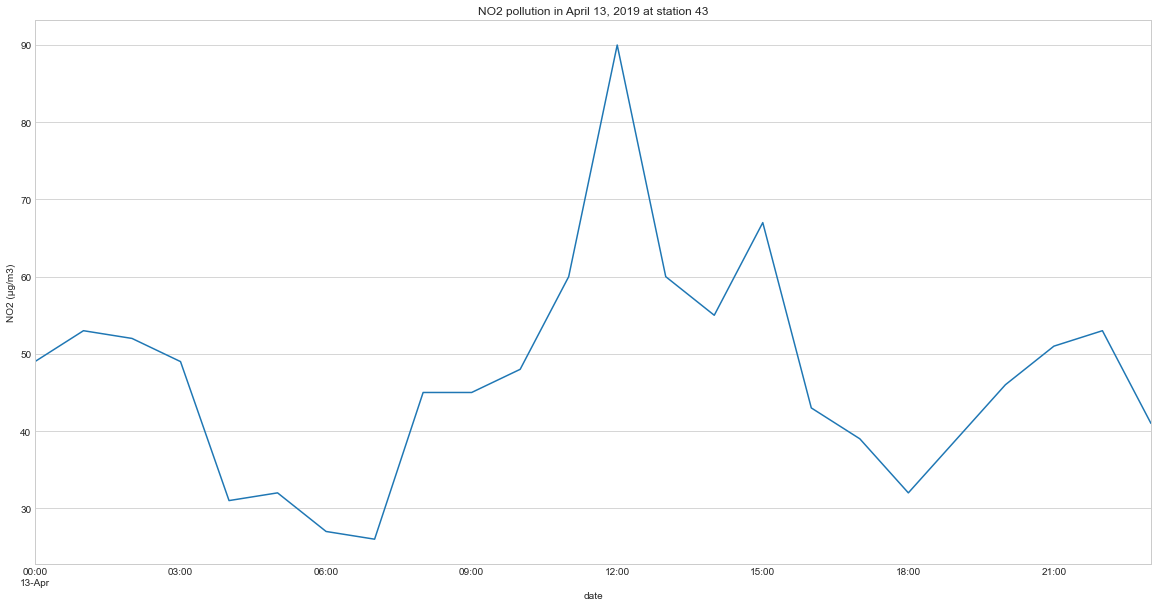

In [177]:
NO2['43'].loc['2019-04-13':'2019-04-13'].plot(figsize=(
    20, 10), title='NO2 pollution in April 13, 2019 at station 43', ylabel='NO2 (μg/m3)')


In [178]:
NO2.describe()

station,4,42,43,44,50,54,57,58
count,24876.000000,24861.000000,24772.000000,24827.000000,24807.000000,24296.000000,24086.000000,19378.000000
mean,29.227770,24.583283,39.937954,34.251178,26.342383,23.237858,20.566429,8.285169
std,18.815481,18.023169,21.892972,20.993519,19.534538,17.979534,17.127900,8.066530
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,14.000000,11.000000,23.000000,18.000000,11.000000,10.000000,9.000000,4.000000
50%,25.000000,19.000000,36.000000,30.000000,21.000000,17.000000,15.000000,6.000000
75%,41.000000,33.000000,53.000000,46.000000,38.000000,31.000000,27.000000,10.000000
max,154.000000,160.000000,207.000000,233.000000,216.000000,181.000000,134.000000,118.000000


As it can be seen, some values are missing due to the stations failing in taking the measurements and therefore they become blanks in the plots.

The overal mean in pollution levels varies from station to station due to their proximity to large sources of emissions (big roads).

The maximum and minimum NO2 concentration levels vary heavily, with a range between +150 μg/m3 and 1 μg/m3. As a reference, the acceptable values of NO2 concentration according to the WHO are 10 μg/m3 on a yearly average or 25 μg/m3 for a daily average.

In [179]:
# We compute the daily, hour-of-the-week, weekly, monthly and yearly averages for each station as well as a global average.

# Dataset import.
NO2 = pd.read_csv('NO2.csv', index_col=0)
NO2.index = pd.to_datetime(NO2.index)
NO2['mean'] = NO2.iloc[:, 0:8].mean(axis=1)
NO2_hourly = NO2
NO2_monthly = NO2.groupby(pd.Grouper(freq='M')).mean()
NO2_daily = NO2.groupby(pd.Grouper(freq='D')).mean()
NO2_weekly = NO2.groupby(pd.Grouper(freq='W')).mean()
NO2_yearly = NO2.groupby(pd.Grouper(freq='Y')).mean()
del NO2_yearly['58']
del NO2_yearly['mean']
NO2_yearly['EU Limit'] = [40, 40, 40, 40] # Taken from the WHO.
NO2_yearly['WHO Guideline'] = [10, 10, 10, 10] # Taken from the WHO.
NO2_hourly['HoW'] = NO2_hourly.index.dayofweek * 24 + (NO2_hourly.index.hour)

# Only first emergency state 2020-03-14 - 2020-05-24.
NO2_hourly_mean = NO2_hourly.groupby(NO2_hourly['HoW']).mean()
soa1 = NO2_hourly.loc['2020-03-14':'2020-05-24'].groupby(NO2_hourly['HoW']).mean()

# Dataframe with data corresponding to normal mobility.
soa_before = NO2_hourly.loc['2019-04-04':'2020-03-13']
soa_after = NO2_hourly.loc['2020-05-24':'2020-10-24']
soa3_after = NO2_hourly.loc['2021-05-09':]
no_soa = pd.concat([soa_before, soa_after, soa3_after], axis=0)
no_soa = no_soa.groupby(NO2_hourly['HoW']).mean()

# Dataframe from third state of alarm.
soa3 = NO2_hourly.loc['2020-05-24':'2020-10-24'].groupby(NO2_hourly['HoW']).mean()

NO2_HoW = pd.DataFrame([no_soa['mean'], soa1['mean'], soa3['mean']]).T
NO2_HoW.columns = ['Normal Mobility', 'First State of Alarm', 'Third State of Alarm']

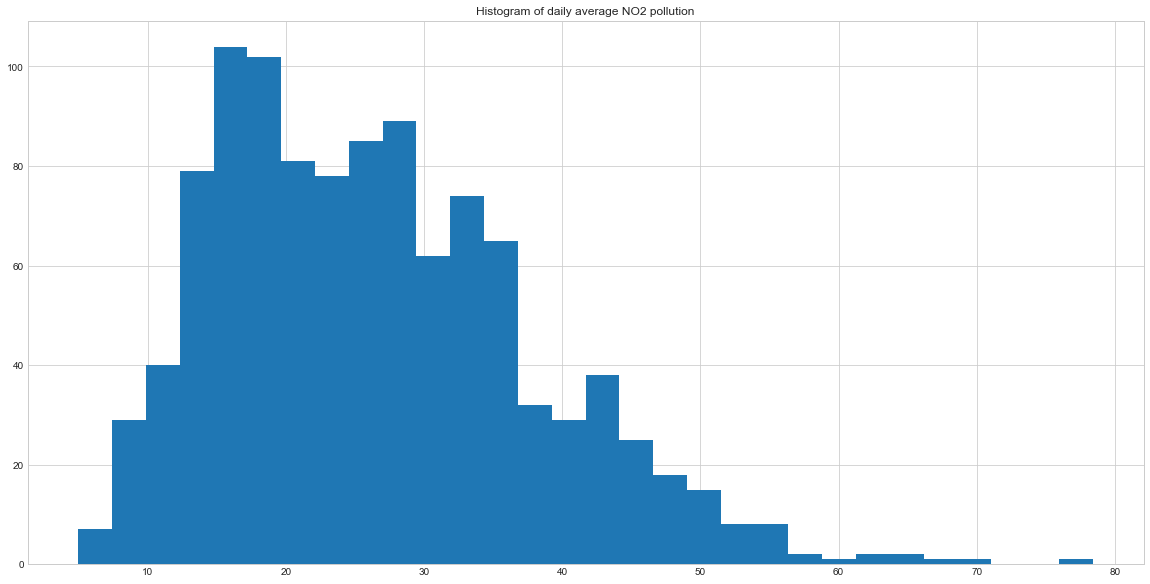

In [180]:
plt.figure(figsize=(20, 10))
plt.hist(NO2_daily['mean'], bins=30, label='Daily')
plt.title('Histogram of daily average NO2 pollution')
plt.show()

The distribution of the NO2 daily pollution levels have as most common numbers the values between 15 and 50 μg/m3 with some cases of either extremely low numbers or extremely high.

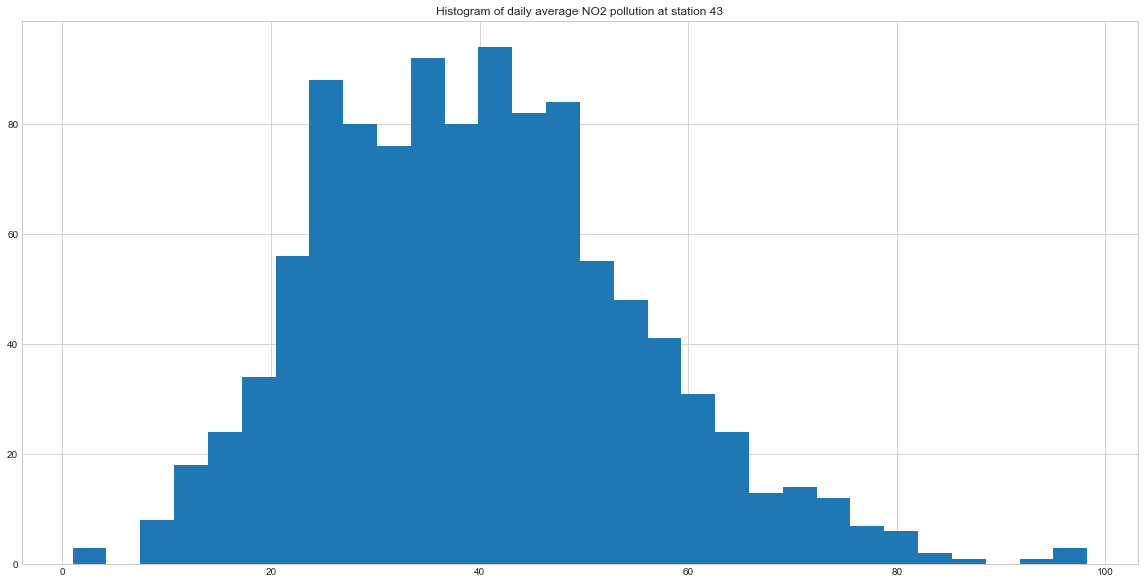

In [181]:
plt.figure(figsize=(20, 10))
plt.hist(NO2_daily['43'], bins=30, label='Daily')
plt.title('Histogram of daily average NO2 pollution at station 43')
plt.show()


In station 43, a traffic station, we see that the distribution is significantly different, having higher values than the global average.

#### Meteorological Data


Additionally to the pollution data, we had to find meteorological data to perform the analysis, which also required to be cleaned and pre-processed. The data was obtained from the meteorological agency of Catalunya. Two datasets had to be merged to contain all the data for the 4 years. The data was on a daily resolution.  

As for the air pollution data, we have created time series which index is the date and rows are the wind and precipitation numbers.

In [182]:
# Data pre-processing for wind & precipitation data.

df_meteo = pd.read_csv('meteo-barcelona-2020-2022.csv')
df_meteo19 = pd.read_csv('meteo-barcelona-2019.csv')
df19 = df_meteo19

In [183]:
#filtering data by average wind velocity (m/s)
filt_WIND = (df_meteo.ACRÒNIM == 'VVM10')
df_meteo_wind = df_meteo[filt_WIND]

#filtering data by accumulated daily rain (mm)
filt_RAIN = (df_meteo.ACRÒNIM == 'PPT')
df_meteo_rain = df_meteo[filt_RAIN]

#filtering data by station (X8=ZONA UNIVERSITARIA) We're gonna use this station as reference
filt_st = (df_meteo_wind.CODI_ESTACIO == 'X8')
df_meteo_wind_st = df_meteo_wind[filt_st]

#droping the innecesary columns
df_meteo_wind_st = df_meteo_wind_st.drop(
    ['DATA_EXTREM', 'CODI_ESTACIO', 'ACRÒNIM'], axis=1)

#changing name of column so it matches the other dataset
df_meteo_wind_st.rename({'VALOR': 'VVM10'}, axis=1, inplace=True)

#filtering data by station (X8=ZONA UNIVERSITARIA) We're gonna use this station as reference
filt_st = (df_meteo_rain.CODI_ESTACIO == 'X8')

df_meteo_rain_st = df_meteo_rain[filt_st]

#droping the innecesary columns
df_meteo_rain_st = df_meteo_rain_st.drop(
    ['DATA_EXTREM', 'CODI_ESTACIO', 'ACRÒNIM'], axis=1)
#changing name of column so it matches the other dataset
df_meteo_rain_st.rename({'VALOR': 'PPT24H'}, axis=1, inplace=True)

In [184]:
#in order to filter the data (we are just interested in 2019)
#we'll create columns where the day month annd year get splited

#we take the data in the format day/month/year and split it in another dataframe
year = df_meteo19['DATA_LECTURA'].str.split('/', expand=True)

#we drop day and moth and just keep year
year = year.drop([0, 1], axis=1)
#we insert this info to the df10 dataframe
df19['year'] = year
#finally we filter all the data annd we end up with just 2019 data
filt_year = (df19['year'] == '2019')
df19 = df19[filt_year]


In [185]:
#we just keep the interesting columns droping all the others
df19_wind = df19.drop(['CODI_ESTACIO', 'TM', 'TX', 'TN', 'HRM', 'PPT24H',
                       'HPA', 'RS24H', 'DVM10', 'VVX10', 'DVX10', 'year'], axis=1)

df19_rain = df19.drop(['CODI_ESTACIO', 'TM', 'TX', 'TN', 'HRM', 'VVM10',
                       'HPA', 'RS24H', 'DVM10', 'VVX10', 'DVX10', 'year'], axis=1)

In [186]:
#finally we merge all the clean data into two dataframe, one containing wind info and the other rain
df_wind = df19_wind
df_wind = df_wind.append(df_meteo_wind_st)
df_rain = df19_rain
df_rain = df_rain.append(df_meteo_rain_st)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [187]:
#the 2 data frameses we mereged had different date formats so we replace all the  '-' to get the same format
df_wind['DATA_LECTURA'] = df_wind['DATA_LECTURA'].str.replace(
    '-', '/', regex=True)
df_rain['DATA_LECTURA'] = df_rain['DATA_LECTURA'].str.replace(
    '-', '/', regex=True)

In [188]:
# Proper timeseries with index.

time = []
# The size of each step in days
day_delta = dt.timedelta(days=1)

start_date = dt.date(year=2019, month=1, day=1)
end_date = dt.date(year=2022, month=4, day=26)

for i in range((end_date - start_date).days):
    time.append(start_date + i*day_delta)
time = pd.to_datetime(time)

In [189]:
wind = df_wind['VVM10']
rain = df_rain['PPT24H']

meteo = pd.DataFrame(wind).reset_index(drop=True)
meteo['PPT24H'] = rain.tolist()
meteo = meteo.set_index(time, drop=True)

meteo['VVM10'] = meteo['VVM10'].astype(float)
meteo['PPT24H'] = meteo['PPT24H'].astype(float)

In [190]:
meteo.describe()

,VVM10,PPT24H
count,1211.000000,1211.000000
mean,2.184558,1.452519
std,0.940741,6.463718
min,0.700000,0.000000
25%,1.600000,0.000000
50%,2.000000,0.000000
75%,2.500000,0.000000
max,8.300000,83.900000


<AxesSubplot:title={'center':'Maximum wind speeds at 10m in Barcelona'}, ylabel='VVM10 (m/s)'>

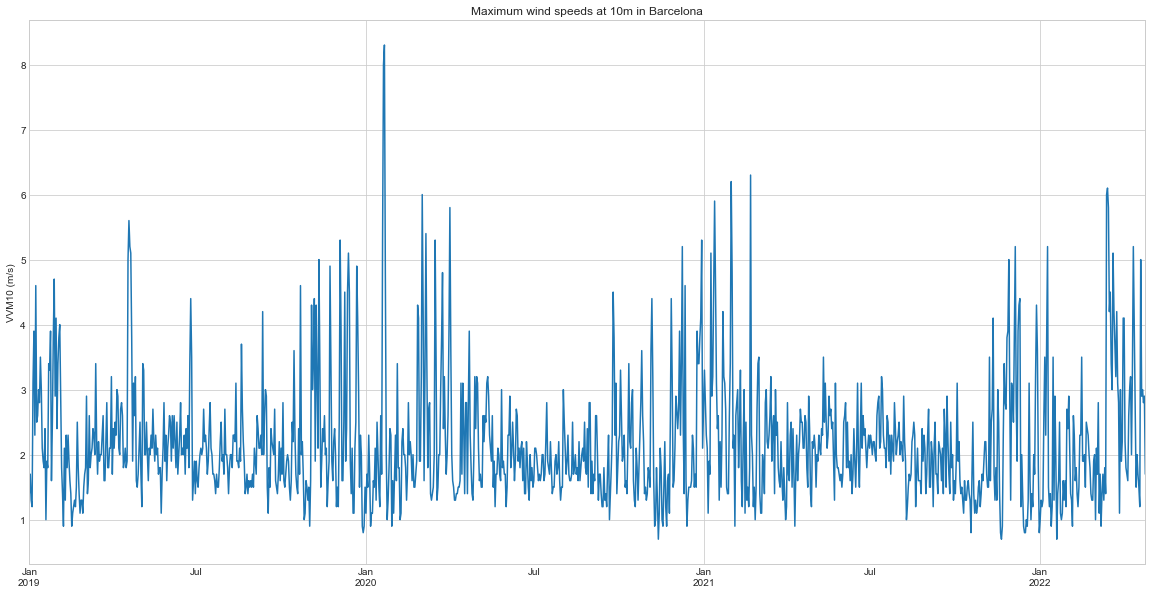

In [191]:
meteo['VVM10'].plot(figsize=(20, 10), title='Maximum wind speeds at 10m in Barcelona', ylabel='VVM10 (m/s)')

We can observe the entire dataset of max wind speeds in the city. As expected we can observe high levels of wind during winter and lower winds during the summer due to the different meteorological conditions.

<AxesSubplot:title={'center':'Daily Precipitations in Barcelona'}, ylabel='Precipitations (mm)'>

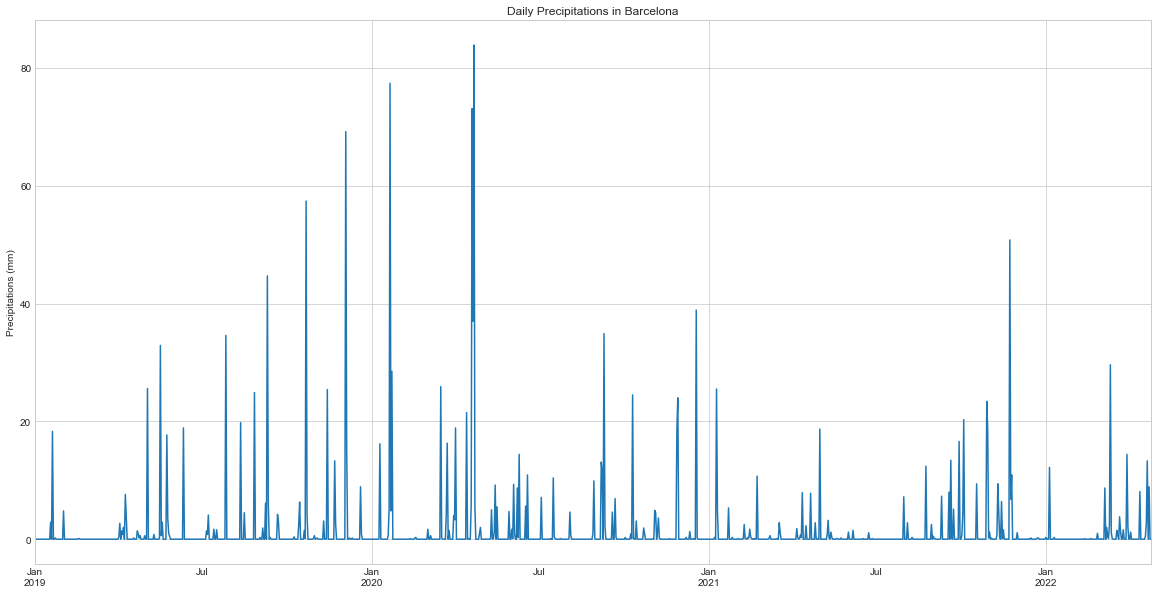

In [192]:
meteo['PPT24H'].plot(figsize=(
    20, 10), title='Daily Precipitations in Barcelona', ylabel='Precipitations (mm)')

#### Restrictions Data

This was the most difficult to obtain. Surprisingly enough, we could not find any dataset online containing the dates and restrictions imposed during the entire pandemic, therefore we created it ourselves manually by reading the Spanish and Catalan Official Journals. We have compiled the restrictions that mostly affected mobility in Barcelona. The data was made into two different dataframes: one with dummy variables for the sake of time series, and the other with the dates of start and end of each restriction for the timeline presented.  


The data was collected manually and generated using a spreadsheet, which is also attached along with the rest of the project.

In [193]:
restriction_dates = pd.read_csv('covid-19-rules-dates.csv')
restriction_dates

,ID,Start,End,Duration
0,all-schools-closed,2020-03-12,2020-09-14,186
1,first-state-of-alarm-state-excl-relax,2020-03-14,2020-05-24,71
2,total-lockdown,2020-03-30,2020-04-09,10
3,relaxing-phase-1,2020-05-25,2020-06-07,13
4,relaxing-phase-2,2020-06-08,2020-06-16,8
5,relaxing-phase-3,2020-06-17,2020-06-18,1
6,third-state-of-alarm,2020-10-25,2021-05-09,196
7,night-curfew-01-to-06,2020-12-14,2021-01-21,38


In [194]:
# Boolean dataframe containing the days where rules were enforced.
restriction_days = pd.read_csv('covid-19-rules-daily.csv')
restriction_days.head()

,datetime,all-schools-closed,first-state-of-alarm-excl-relax,total-lockdown,relaxing-phase-1,relaxing-phase-2,relaxing-phase-3,third-state-of-alarm,night-curfew-01-to-06
0,02/04/2019,0,0,0,0,0,0,0,0
1,03/04/2019,0,0,0,0,0,0,0,0
2,04/04/2019,0,0,0,0,0,0,0,0
3,05/04/2019,0,0,0,0,0,0,0,0
4,06/04/2019,0,0,0,0,0,0,0,0


## 3. Data Analysis

### Initial plots

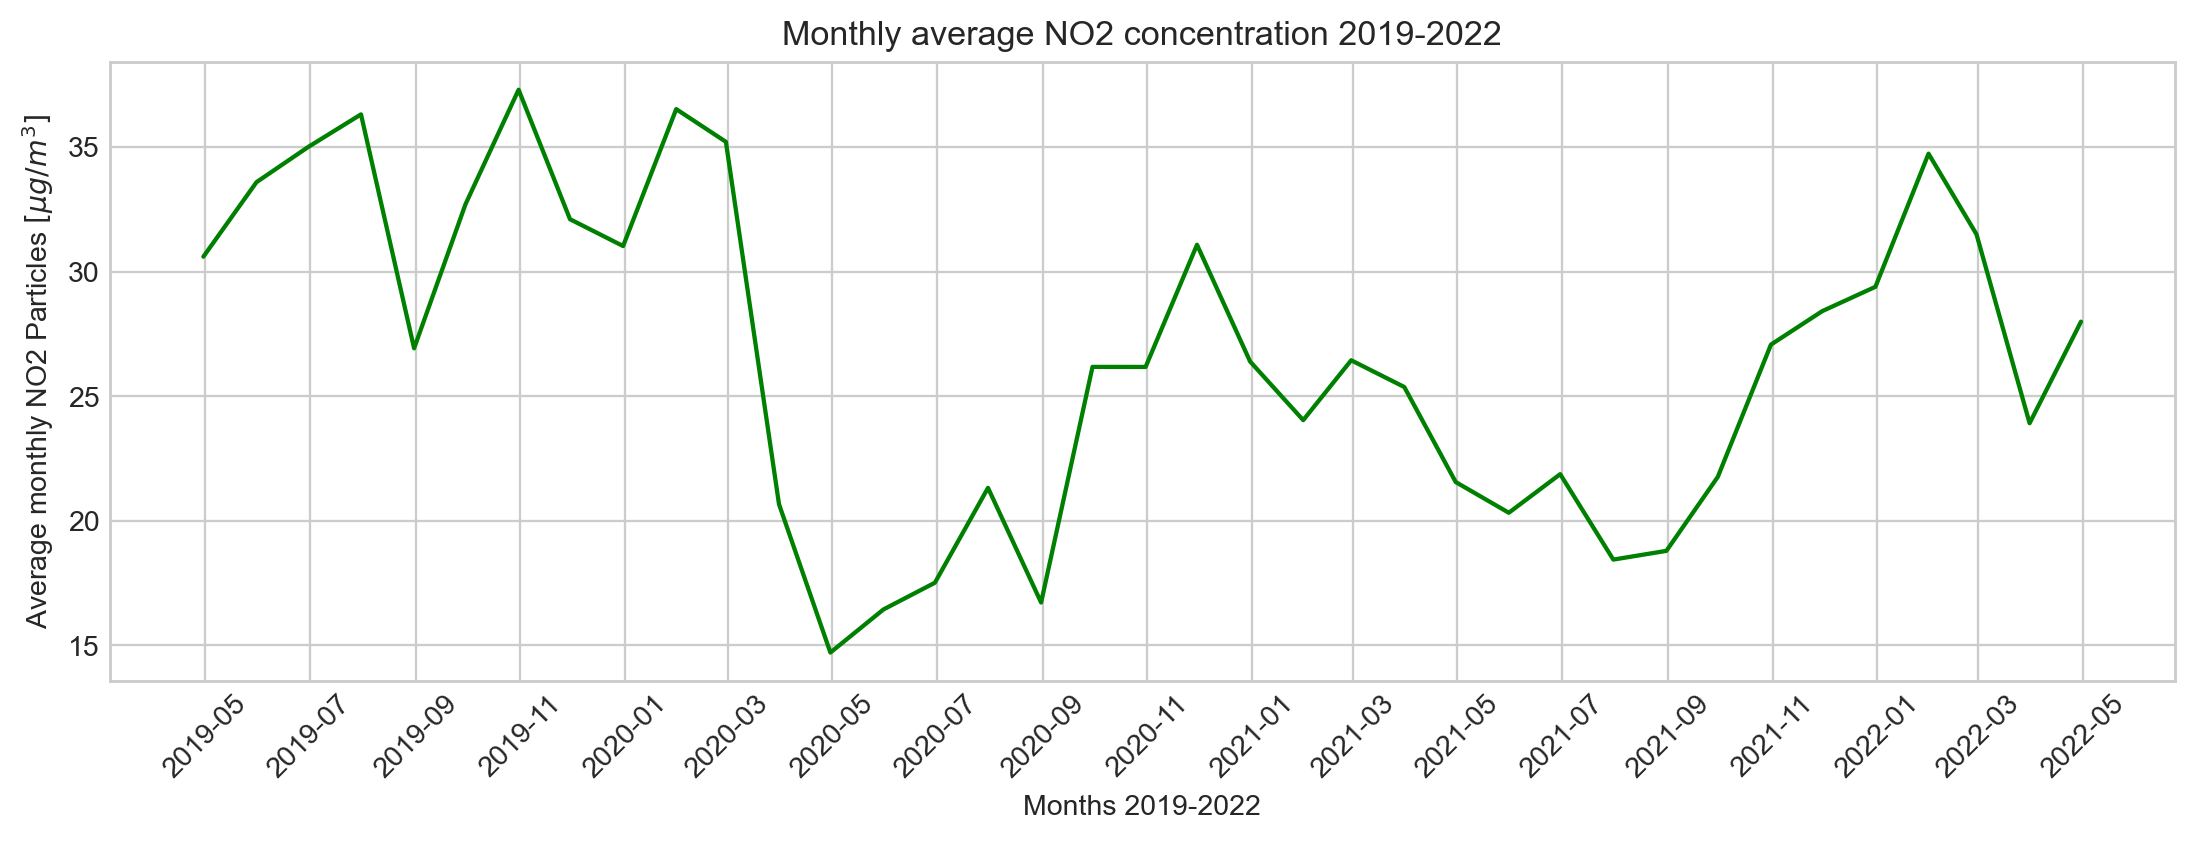

In [195]:
plt.figure(figsize=(13, 4), dpi=205)

# label="average NO2 particles" ,markevery=markers_on
plt.plot(NO2_monthly.index, NO2_monthly['mean'], '-g')
plt.title("Monthly average NO2 concentration 2019-2022")
plt.xlabel("Months 2019-2022")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.ylabel(r"Average monthly NO2 Particles $[\mu g / m^3]$")
plt.xticks(rotation=45)


plt.show()


In the previous plot we can see how the monthly average NO2 concentration decreased heavily at the same time as the pandemic lockdown was put in place.

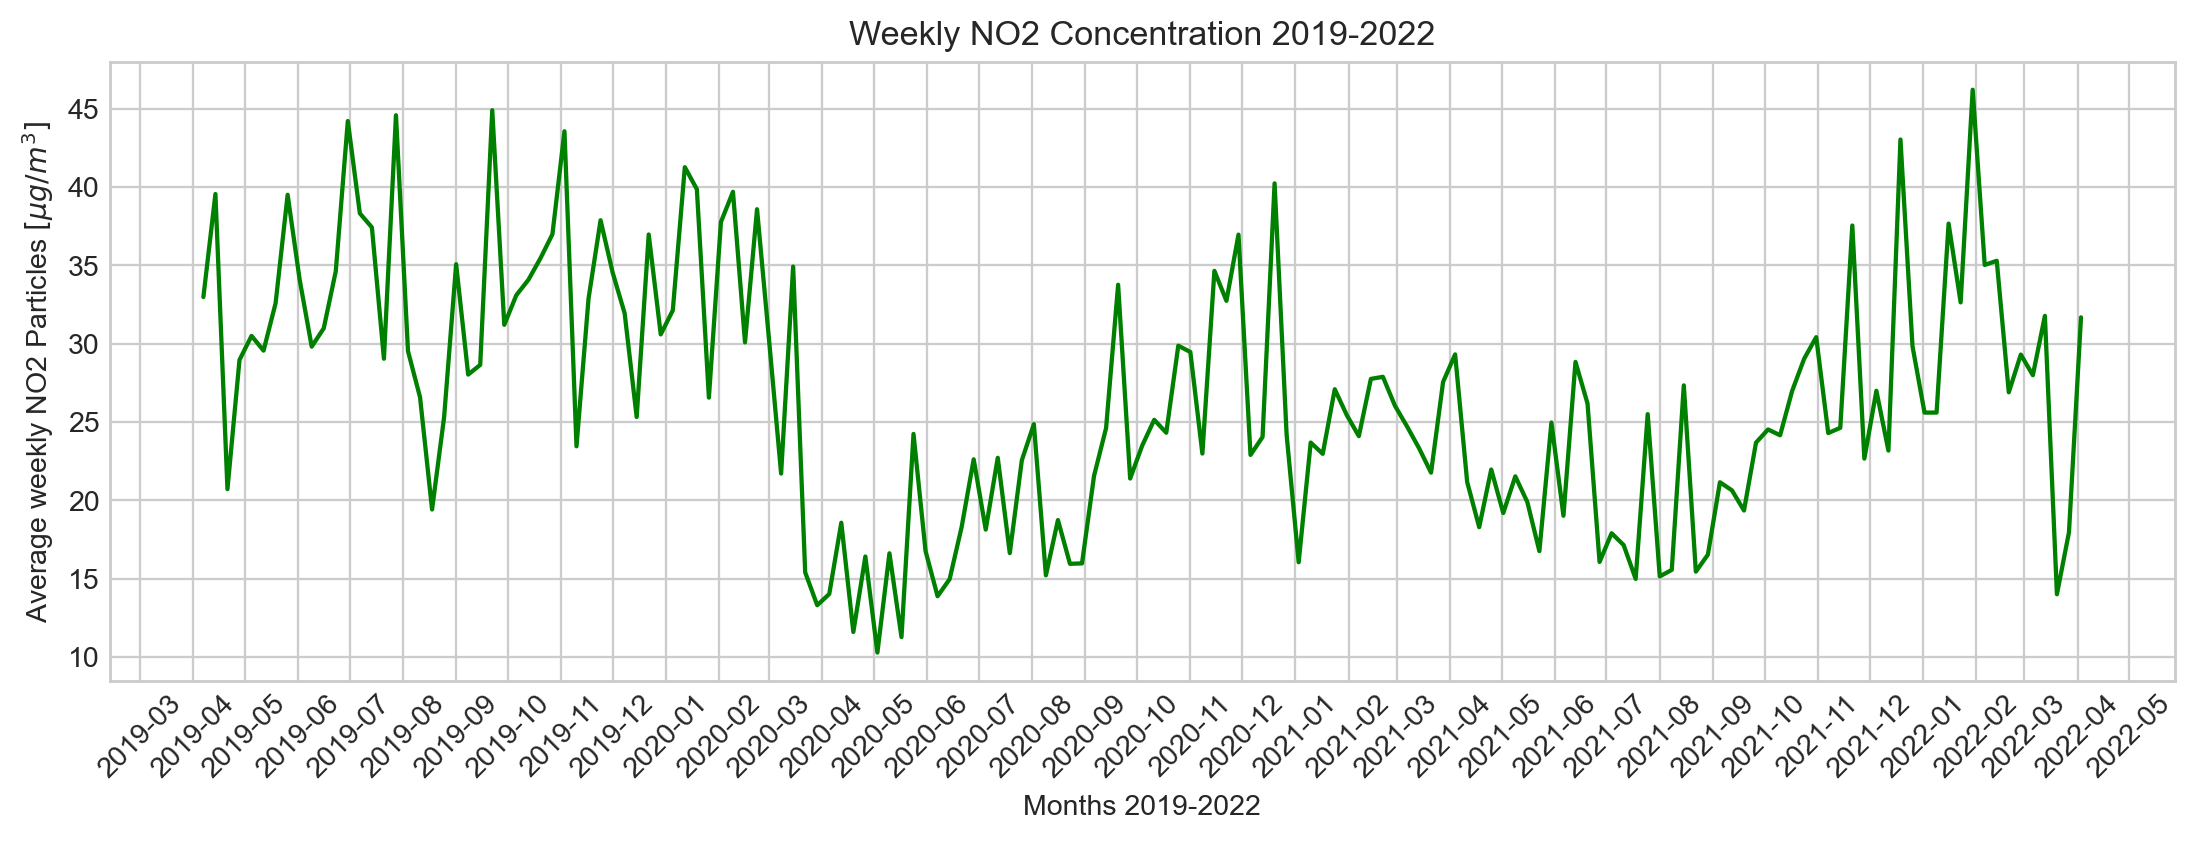

In [196]:
plt.figure(figsize=(13, 4), dpi=205)


# label="average NO2 particles" ,markevery=markers_on
plt.plot(NO2_weekly.index, NO2_weekly['mean'], '-g')
plt.title("Weekly NO2 Concentration 2019-2022")
plt.xlabel("Months 2019-2022")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.ylabel(r"Average weekly NO2 Particles $[\mu g / m^3]$")
plt.xticks(rotation=45)


plt.show()


The weekly values show the same trend, but they show higher fluctuations that might be due to meteorological conditions and change of habits of the population. The minimum value of average weekly NO2 concentration was achieved exactly in the works weeks of the pandemic, when a total lockdown was inplace.

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.


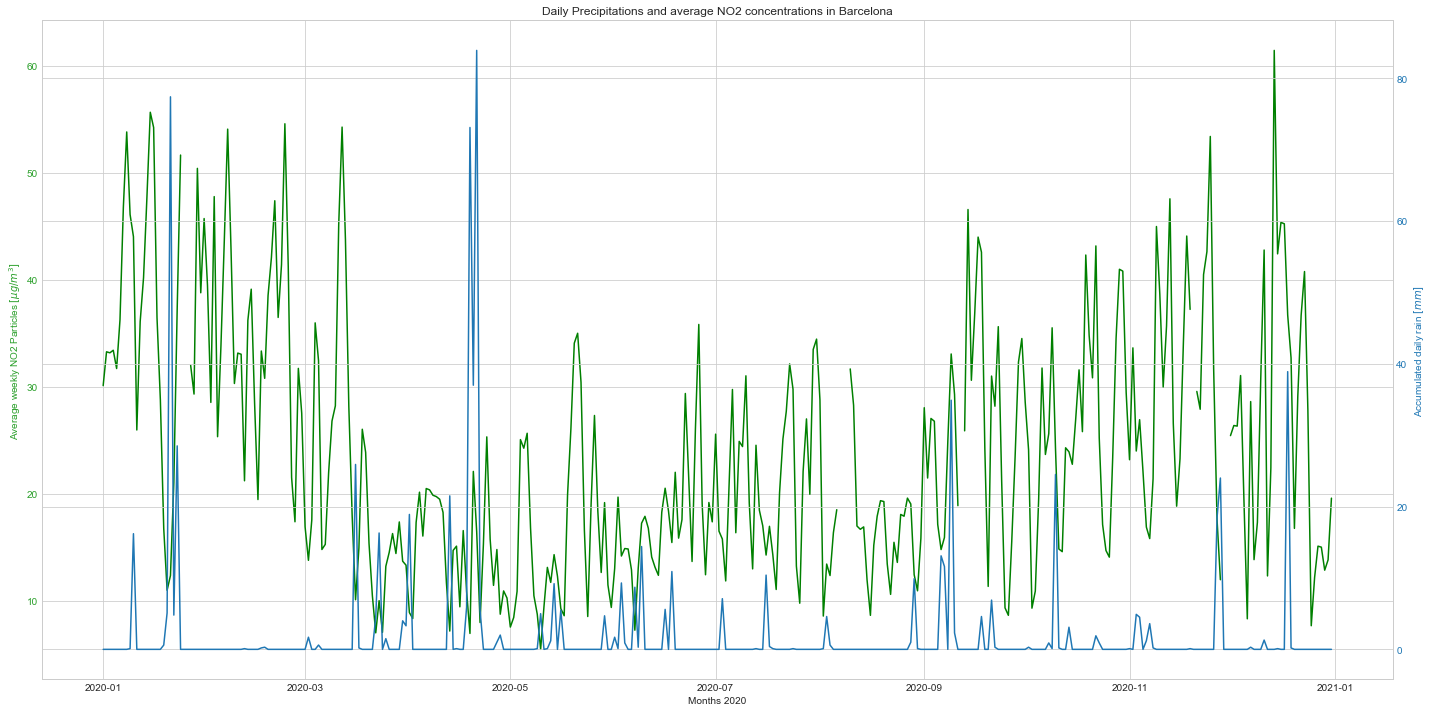

In [197]:
plt.rcParams["figure.figsize"] = (20, 10)
fig, ax1 = plt.subplots()

plt.title("Daily Precipitations and average NO2 concentrations in Barcelona")


color = 'tab:green'
#ax1.title("Daily NO2 Particles Pollution 2019-2022")
ax1.set_xlabel("Months 2020")
ax1.set_ylabel(r"Average weekly NO2 Particles $[\mu g / m^3]$", color=color)
# label="average NO2 particles" ,markevery=markers_on
ax1.plot(NO2_daily['2020'].index, NO2_daily['2020']['mean'], '-g', label="Pollution")

ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
# we already handled the x-label with ax1
ax2.set_ylabel(r"Accumulated daily rain $[ mm ]$", color=color)
ax2.plot(meteo['2020'].index, meteo['2020']['PPT24H'], label="Rain")
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


By plotting the precipitations next to the NO2 concentration levels we wanted to find some sort of a pattern, although we haven't seen any specific insight.

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.


Text(0.5, 0, 'Daily NO2 Concentration [μg/m3]')

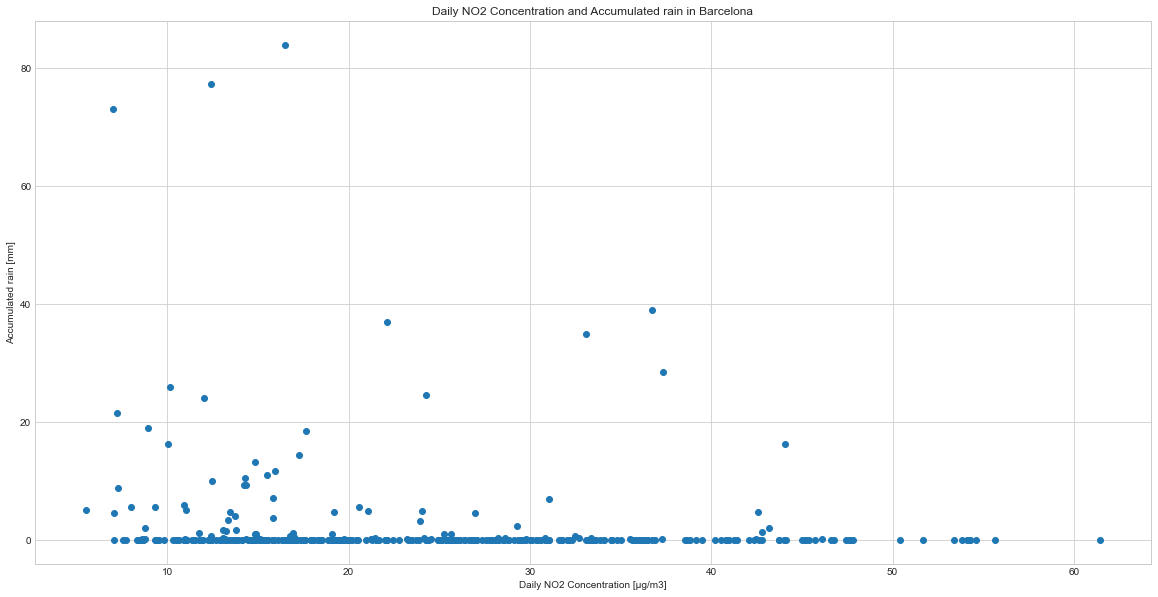

In [198]:
plt.scatter(x=NO2_daily['2020']['mean'], y=meteo['2020']['PPT24H'])
plt.title("Daily NO2 Concentration and Accumulated rain in Barcelona")
plt.ylabel('Accumulated rain [mm]')
plt.xlabel('Daily NO2 Concentration [μg/m3]')

The scatterplot does not show any specific relation that we can observe between the two variables.

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.


Text(0.5, 0, 'Daily NO2 Concentration [μg/m3]')

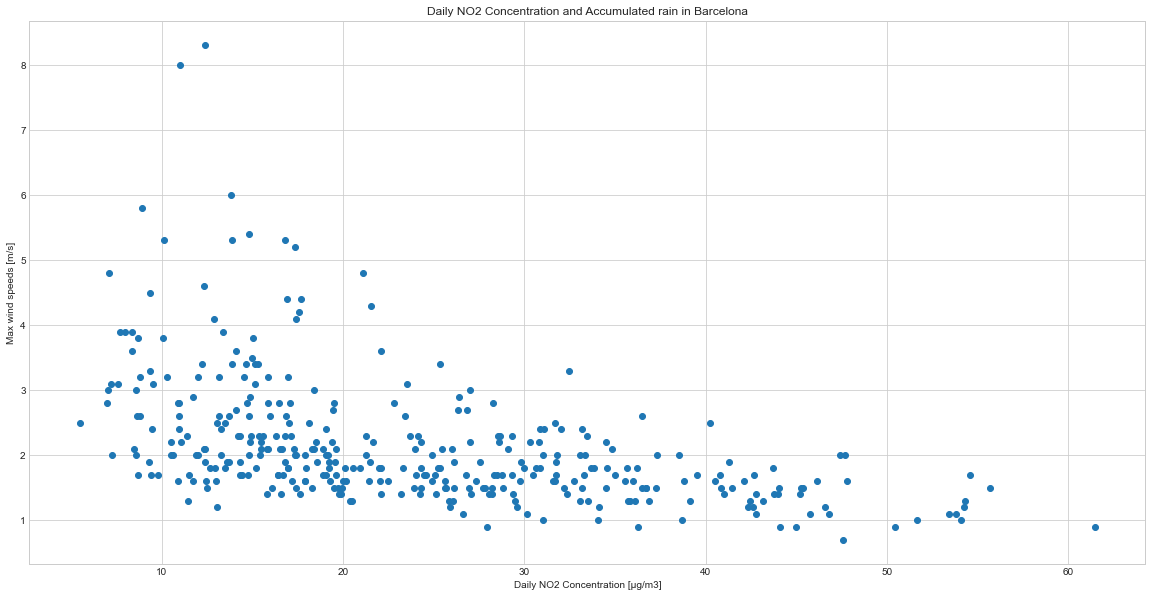

In [199]:
plt.scatter(x=NO2_daily['2020']['mean'], y=meteo['2020']['VVM10'])
plt.title("Daily NO2 Concentration and Accumulated rain in Barcelona")
plt.ylabel('Max wind speeds [m/s]')
plt.xlabel('Daily NO2 Concentration [μg/m3]')


We can, however, se a relationship between the wind speeds and the level of concentration of NO2. It seems to have an inverse relation (more wind --> less pollution), which sounds logical.

### Map and yearly trend

Firstly we want to understand where are the stations located, so we drew a map with the locations.

In [200]:
# Map of where the stations are present in Barcelona.
import folium

bcn = folium.Map(location=[41.3874, 2.169],
                 zoom_start=12, tiles='Stamen Terrain')
folium.Marker([41.4039, 2.2045], popup='Station 4: Poblenou',
              icon=folium.Icon(color='blue')).add_to(bcn)
folium.Marker([41.3788, 2.1331], popup='Station 42: Sants',
              icon=folium.Icon(color='blue')).add_to(bcn)
folium.Marker([41.3853, 2.1538], popup='Station 43: Eixample',
              icon=folium.Icon(color='red')).add_to(bcn)
folium.Marker([41.3987, 2.1534], popup='Station 44: Gràcia',
              icon=folium.Icon(color='red')).add_to(bcn)
folium.Marker([41.3864, 2.1874], popup='Station 50: Ciutadella',
              icon=folium.Icon(color='blue')).add_to(bcn)
folium.Marker([41.4261, 2.1480], popup='Station 54: Vall Hebrón',
              icon=folium.Icon(color='blue')).add_to(bcn)
folium.Marker([41.3875, 2.1151], popup='Station 57: Palau Reial',
              icon=folium.Icon(color='blue')).add_to(bcn)

bcn.save(outfile="stations.html")
bcn


The stations are located around the city, and the two red ones are next to majour traffic roads, hence measuring the air close to big traffic hotspots. That is the reason why the measurements in those two stations are always higher than in the others.

In order to know how compliant Barcelona's air quality is with the standards set by the EU and WHO, we plot the yearly average levels per station.

In [201]:
NO2_yearly.columns = ['Station 4',
                      'Station 42',
                      'Station 43 (T)',
                      'Station 44 (T)',
                      'Station 50',
                      'Station 54',
                      'Station 57',
                      'EU Limit',
                      'WHO Guideline']
NO2_yearly.index = ['2019', '2020', '2021', '2022']
fig = px.line(NO2_yearly)
fig.update_layout(
    title="Yearly average NO2 concentration levels in Barcelona",
    legend_title="Station"
)
fig.update_yaxes(
    title="NO2 [µg/m3]"
)
fig.update_xaxes(
    title="Year"
)
fig.show()
fig.write_html("yearly_average.html", full_html=False, include_plotlyjs='cdn')


During the 4 years in the analysis, it seems that Barcelona has followed the EU standards besides in one of the traffic stations. However, it has never achieved the guidelines recommended by the WHO.

### Weekly evolution

We wanna understand the weekly evolution of NO2 concentration with an hourly resolution. We plot that in an interactive way and we distinguish between the periods of normal mobility, first lockdown, and third lockdown.

In [202]:
# Plot of a week per hours by station number.

fig = px.line(NO2_HoW)

for i in [20+(24*x) for x in range(0,7)]:
    fig.add_vline(
        x=i,
        line_width=1, 
        line_dash="dash", 
        line_color="green",
    )

    fig.add_annotation(
    x=i-1, 
    y=46,
    text="20:00",
    showarrow=False,
    textangle=-90,
    font=dict(
            family="Tahoma, monospace",
            size=10,
            color="Green",
            )
    )



for i in [9+(24*x) for x in range(0,7)]:
    fig.add_vline(
        x=i,
        line_width=1, 
        line_dash="dot", 
        line_color="black",
    )

    fig.add_annotation(
    x=i-1, 
    y=46,
    text="09:00",
    showarrow=False,
    textangle=-90,
    font=dict(
            family="Tahoma, monospace",
            size=10,
            color="Black",
            )
    )

fig.update_xaxes(
    title="Hour of the week"
)

fig.update_yaxes(
    title="NO2 [µg/m3]"
)

fig.update_layout(
    title="Weekly average NO2 concentration levels by hour for all stations in Barcelona",
    legend_title="Series"
)

fig.show()
fig.write_html("weekly_average.html", full_html=False, include_plotlyjs='cdn')

This is perhaps one of the most insightful graphs: we can understand the trend of emissions per hour, with the clear peaks around 09:00 and 20:00 due to those periods being traffic peaks, but we can also observe the difference during the pandemic! During the third state of alarm, emissions decreased significantly with respect to the normal mobility period, but tended to keep the same trend and peaks. During the first state of alarm the values decreased even more and the trend of the series also suffered modifications, specifically in the evening hours.

### Restrictions timeline

In order to visualize when the rules were in place we plotted the following graph:

In [203]:
rules = pd.read_csv('covid-19-rules-dates.csv')
fig = px.timeline(rules, x_start="Start", x_end="End", y="ID",
                  title='Timeline of COVID-19 restrictions in Barcelona')
fig.update_yaxes(autorange="reversed")

note = 'Gathered by authors, based on Royal Decree-Laws 463/2020, 10/2020, 962/2020 and catsalut.gencat.cat'
fig.add_annotation(
    text=note,
    showarrow=False,
    x=0,
    y=-0.15,
    xref='paper',
    yref='paper',
    xanchor='left',
    yanchor='bottom',
    xshift=-1,
    yshift=-5,
    font=dict(size=10, color="grey"),
    align="left"
)

fig.show()
fig.write_html("output.html", full_html=False, include_plotlyjs='cdn')


Some of the restrictions, such as the total lockdown that prohibited for all individuals to go out of their homes besides to do essential work or tasks, lasted for very small periods of time. Other restrictions like the first emergency state lasted for a few months. We will compare these restrictions with the changes in NO2 concentration levels to try to find the correlation between them.

In order to combine the regulations with the full time series of restrictions, we plotted the following graph:

In [204]:
fig = px.line(
    NO2_weekly['mean']
)

fig.add_trace(
    go.Scatter(
        name='Station 4',
        y=NO2_weekly['4'],
        x=NO2_weekly.index,
        visible='legendonly',
    )
)

fig.add_trace(
    go.Scatter(
        name='Station 42',
        y=NO2_weekly['42'],
        x=NO2_weekly.index,
        visible='legendonly',
    )
)

fig.add_trace(
    go.Scatter(
        name='Station 43',
        y=NO2_weekly['43'],
        x=NO2_weekly.index,
        visible='legendonly',
    )
)

fig.add_trace(
    go.Scatter(
        name='Station 44',
        y=NO2_weekly['44'],
        x=NO2_weekly.index,
        visible='legendonly',
    )
)

fig.add_trace(
    go.Scatter(
        name='Station 50',
        y=NO2_weekly['50'],
        x=NO2_weekly.index,
        visible='legendonly',
    )
)

fig.add_trace(
    go.Scatter(
        name='Station 54',
        y=NO2_weekly['54'],
        x=NO2_weekly.index,
        visible='legendonly',
    )
)

fig.add_trace(
    go.Scatter(
        name='Station 57',
        y=NO2_weekly['57'],
        x=NO2_weekly.index,
        visible='legendonly',
    )
)

fig.update_layout(
    title="Weekly average NO2 concentration levels in Barcelona during 2020",
    legend_title="Station"
)

fig.update_xaxes(
    title="Date"
)

fig.update_yaxes(
    title="NO2 [µg/m3]"
)


fig.add_vrect(
    x0="2020-03-15", x1="2020-05-24",
    fillcolor="LightGrey", opacity=1,
    layer="below", line_width=0
)

fig.add_vrect(
    x0="2020-05-24", x1="2020-06-07",
    fillcolor="LightGrey", opacity=0.6,
    layer="below", line_width=0,
)


fig.add_vrect(
    x0="2020-06-07", x1="2020-06-16",
    fillcolor="LightGrey", opacity=0.3,
    layer="below", line_width=0,
)

fig.add_vrect(
    x0="2020-06-16", x1="2020-06-18",
    fillcolor="LightBlue", opacity=0.4,
    layer="below", line_width=0,
)

fig.add_vrect(
    x0="2020-06-18", x1="2020-10-25",
    fillcolor="Orange", opacity=0.1,
    layer="below", line_width=0,
)

fig.add_vrect(
    x0="2020-10-25", x1="2021-05-09",
    fillcolor="Yellow", opacity=0.2,
    layer="below", line_width=0,
)

fig.add_annotation(
    x='2020-04-18', 
    y=55,
    text="First<br>State of<br>Alarm",
    showarrow=False,
    font=dict(
            family="Tahoma, monospace",
            size=10,
            color="Black",
            )
)

fig.add_annotation(
    x='2020-05-30', 
    y=50,
    text="Phase <br>1",
    showarrow=False,
    font=dict(
            family="Tahoma, monospace",
            size=8,
            color="Black",
            )
)

fig.add_annotation(
    x='2020-06-11', 
    y=40,
    text="Phase<br> 2",
    showarrow=True,
    font=dict(
            family="Tahoma, monospace",
            size=8,
            color="Black",
            )
)

fig.add_annotation(
    x='2021-01-30', 
    y=56,
    text="Third<br>State of<br>Alarm",
    showarrow=False,
    font=dict(
            family="Tahoma, monospace",
            size=8,
            color="Black",
            )
)

fig.add_annotation(
    x='2020-06-17', 
    y=55,
    text="Phase<br> 3",
    showarrow=True,
    font=dict(
            family="Tahoma, monospace",
            size=11,
            color="Black",
            ),
    yshift=10
)

fig.add_annotation(
    x='2020-08-15', 
    y=50,
    text="New Normal",
    showarrow=False,
    font=dict(
            family="Tahoma, monospace",
            size=11,
            color="Black",
            ),
    yshift=10
)

fig.show()
fig.write_html("full-time-series.html", full_html=False, include_plotlyjs='cdn')

While the first emergency state seems to have had a high impact on the NO2 concentration levels if we only take into account the previous visualization, it is not evident that the third emergency state had the same impact. It is easy to understand why: the third emergency state only limited mobility in a small extent, with recommended remote work and possibility to go out freely to work and to do leisure activities. It is also possible to observe thanks to the previous plot how the trend in all stations is the same, but showing slightly higher or lower values.  

However, we cannot state that the values of NO2 concentration were not affected by it, to be able to do that we must remove the effects caused by meteorological factors.



### Heatmap Video

We wanted to observe the evolution of pollution through a heatmap video, so we created the following:

In [205]:
# Specific imports
import pdb

from folium import plugins
from folium.plugins import HeatMap
import os


In [206]:
NO2_ori_data = pd.read_csv("./NO2.csv")
PM10_ori_data = pd.read_csv("./PM10.csv")
PM25_ori_data = pd.read_csv("./PM25.csv")

NO2_ori_data['date'] = pd.to_datetime(NO2_ori_data['date'])
PM10_ori_data['date'] = pd.to_datetime(PM10_ori_data['date'])
PM25_ori_data['date'] = pd.to_datetime(PM25_ori_data['date'])

NO2_ori_data['weekofyear'] = NO2_ori_data['date'].apply(lambda x: x.weekofyear)
PM10_ori_data['weekofyear'] = PM10_ori_data['date'].apply(
    lambda x: x.weekofyear)
PM25_ori_data['weekofyear'] = PM25_ori_data['date'].apply(
    lambda x: x.weekofyear)

NO2_ori_data['year'] = NO2_ori_data['date'].apply(lambda x: x.year)
PM10_ori_data['year'] = PM10_ori_data['date'].apply(lambda x: x.year)
PM25_ori_data['year'] = PM25_ori_data['date'].apply(lambda x: x.year)

In [207]:
NO2_2019_data = NO2_ori_data[NO2_ori_data['year'] == 2019]
NO2_2020_data = NO2_ori_data[NO2_ori_data['year'] == 2020]
NO2_2021_data = NO2_ori_data[NO2_ori_data['year'] == 2021]
NO2_2022_data = NO2_ori_data[NO2_ori_data['year'] == 2022]

PM10_2019_data = PM10_ori_data[PM10_ori_data['year'] == 2019]
PM10_2020_data = PM10_ori_data[PM10_ori_data['year'] == 2020]
PM10_2021_data = PM10_ori_data[PM10_ori_data['year'] == 2021]
PM10_2022_data = PM10_ori_data[PM10_ori_data['year'] == 2022]

PM25_2019_data = PM25_ori_data[PM25_ori_data['year'] == 2019]
PM25_2020_data = PM25_ori_data[PM25_ori_data['year'] == 2020]
PM25_2021_data = PM25_ori_data[PM25_ori_data['year'] == 2021]
PM25_2022_data = PM25_ori_data[PM25_ori_data['year'] == 2022]


In [208]:
def process(x):
    split_station = x.dropna()
    if split_station.shape[0] == 0:
        return 0
    return sum(split_station) / len(split_station)


In [209]:
NO2_new_data_2019 = pd.DataFrame()
NO2_new_data_2020 = pd.DataFrame()
NO2_new_data_2021 = pd.DataFrame()
NO2_new_data_2022 = pd.DataFrame()

for station in ['4', '42', '43', '44', '50', '54', '57']:
    NO2_new_data_2019[station] = NO2_2019_data.groupby(
        'weekofyear')[station].apply(lambda x: process(x))
for station in ['4', '42', '43', '44', '50', '54', '57']:
    NO2_new_data_2020[station] = NO2_2020_data.groupby(
        'weekofyear')[station].apply(lambda x: process(x))
for station in ['4', '42', '43', '44', '50', '54', '57']:
    NO2_new_data_2021[station] = NO2_2021_data.groupby(
        'weekofyear')[station].apply(lambda x: process(x))
for station in ['4', '42', '43', '44', '50', '54', '57']:
    NO2_new_data_2022[station] = NO2_2022_data.groupby(
        'weekofyear')[station].apply(lambda x: process(x))

NO2_new_data_2019 = NO2_new_data_2019.reset_index()
NO2_new_data_2020 = NO2_new_data_2020.reset_index()
NO2_new_data_2021 = NO2_new_data_2021.reset_index()
NO2_new_data_2022 = NO2_new_data_2022.reset_index()


In [210]:
after_append_NO2 = NO2_new_data_2019.append(NO2_new_data_2020).append(
    NO2_new_data_2021).append(NO2_new_data_2022)
after_append_NO2['weekofyear'] = [i for i in range(after_append_NO2.shape[0])]

dict_station_loc_NO2 = {
    '4': [41.4039, 2.2045],
    '42': [41.3788, 2.1331],
    '43': [41.3853, 2.1538],
    '44': [41.3987, 2.1534],
    '50': [41.3864, 2.1874],
    '54': [41.4261, 2.1480],
    '57': [41.3875, 2.1151],
}
data_with_week_stations_NO2 = {}

for index, row in after_append_NO2.iterrows():
    # pdb.set_trace()
    week_of_year = int(row['weekofyear'])
    data_with_week_stations_NO2[week_of_year] = list()

    for station, loc in dict_station_loc_NO2.items():
        # if key == 'weekofyear':
        #     continue
        weight = row[station]
        data_with_week_stations_NO2[week_of_year].append(
            [loc[0], loc[1], weight])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [211]:
final_list_NO2 = []
for i in range(len(data_with_week_stations_NO2.keys())):
    final_list_NO2.append(data_with_week_stations_NO2[i])


In [212]:
def create_assist_date():
    datestart = "2019-04-15"
    dateend = '2022-04-28'
    datestart = dt.datetime.strptime(datestart, '%Y-%m-%d')
    dateend = dt.datetime.strptime(dateend, '%Y-%m-%d')
    date_list = []
    date_list.append(datestart.strftime('%d/%m/%Y'))
    while datestart < dateend:
        # 日期叠加一天
        datestart += dt.timedelta(days=+7)
        date_list.append(datestart.strftime('%d/%m/%Y'))
    return date_list


date_list_NO2 = create_assist_date()

for i in range(len(final_list_NO2)):
    for j in range(len(final_list_NO2[i])):
        final_list_NO2[i][j][2] = final_list_NO2[i][j][2] / 100


In [213]:
from folium.plugins import HeatMap, HeatMapWithTime
map_NO2 = folium.Map(location=[41.3874, 2.1686], zoom_start=13)
# 4
folium.Marker([41.4039, 2.2045], popup='POBLE',
              icon=folium.Icon(color='green')).add_to(map_NO2)
# 42
folium.Marker([41.3788, 2.1331], popup='SANTS',
              icon=folium.Icon(color='blue')).add_to(map_NO2)
# 43
folium.Marker([41.3853, 2.1538], popup='EIXAMPLE',
              icon=folium.Icon(color='red')).add_to(map_NO2)
# 44
folium.Marker([41.3987, 2.1534], popup='GRACIA',
              icon=folium.Icon(color='orange')).add_to(map_NO2)
# 50
folium.Marker([41.3864, 2.1874], popup='CIUTADELLA',
              icon=folium.Icon(color='pink')).add_to(map_NO2)
# 54
folium.Marker([41.4261, 2.1480], popup='VALL HEBRON',
              icon=folium.Icon(color='darkpurple')).add_to(map_NO2)
# 57
folium.Marker([41.3875, 2.1151], popup='PALAU REIAL',
              icon=folium.Icon(color='black')).add_to(map_NO2)

HeatMapWithTime(final_list_NO2, index=date_list_NO2,
                auto_play=True, show=True, radius=100).add_to(map_NO2)
map_NO2


In the previous video we can see the evolution of pollution from the different stations, however since this information did not add a lot of value to the article it was not included in the end.

### Modelling & Correlations

In order to analyse the effect of each COVID-19 restriction on the NO2 concentration levels, we have conducted ann analysis to try to observe the correlations that exist between the different variables.

Initially, we run a simple correlation function and later on we model a Random Forest Regressor in order to find the relevant parameters that played a role in the NO2 concentration levels.

The model takes into account the dataset of meteorological conditions, the self-generated dataset on restrictions and the pollution levels.

In [214]:
rules_dummy = pd.read_csv('covid-19-rules-daily.csv', index_col=0)
rules_dummy.index = pd.to_datetime(rules_dummy.index)

Parsing '13/04/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '14/04/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '15/04/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '16/04/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '17/04/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '18/04/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '19/04/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '20/04/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '21/04/2019' in DD/MM/YYYY forma

In [215]:
# Putting all the data together.
df = rules_dummy.merge(NO2_daily['mean'], left_index=True, right_index=True)
df = df.merge(meteo.loc['2019-04-04':'2022-03-04'],
              left_index=True, right_index=True)


In [216]:
df['PPT24H'] = df['PPT24H'].astype(float)
df['VVM10'] = df['VVM10'].astype(float)
df = df.sort_index()
df.columns = ['All schools closed',
              'First state of alarm excl. relax.',
              'Total lockdown',
              'Relax. phase 1',
              'Relax. phase 2',
              'Relax. phase 3',
              'Third state of alarm',
              'Curfew 01:00–06:00',
              'NO2 concentration',
              'Wind',
              'Precipitation']


In [217]:
corr = df.corr()

trace = go.Heatmap(z=corr.values,
                   x=corr.index.values,
                   y=corr.columns.values,

                   )

fig = go.Figure()
fig.add_trace(trace)
fig.update_layout(
    title="Correlation heatmap of the NO2 concentration & meteorological conditions"
)
fig.show()
fig.write_html("correlation.html", full_html=False, include_plotlyjs='cdn')


As shown in the previous plot, the variables that are most correlated with the NO2 concentration are the wind at 10m height (- 0.48!), the variable related to the first emergency state (~0.2).

Because the closure of schools is implicit in the first emergency state, we decide to remove it form the model.

In order to further down on our analysis of impacts, we have modelled a Random Forest to try to infer the levels of NO2 concentration at a certain time. Although we have not managed to make a model that has a high level of accuracy (R2 ≈ 0.3) we believe that the interpretation of the feature importance that the model presents can be representative of the influence created by the different lockdown restrictions. In other words, we think that the importance that our model gave to each variable can be a limited picture of the importance that each variable actually had for influencing the NO2 concentration levels. In the future plot a ranking of the importance of each variable is shown.

In [218]:
# Random Forest Regression
df_clean = df.dropna()
x = df_clean[['First state of alarm excl. relax.',
              'Total lockdown',
              'Relax. phase 1',
              'Relax. phase 2',
              'Relax. phase 3',
              'Third state of alarm',
              'Curfew 01:00–06:00',
              'Wind',
              'Precipitation']]

y = df_clean[['NO2 concentration']]


x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, shuffle=False)


In [219]:
rf = RandomForestRegressor(
    random_state=42,
    #n_estimators=10,
)
rf.fit(x_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(random_state=42)

In [220]:

from sklearn.metrics import r2_score
y_pred_train = rf.predict(x_train)
y_pred_test = rf.predict(x_test)
y_pred = rf.predict(x)

# Metrics

errors_train = r2_score(y_train, y_pred_train)
errors_test = r2_score(y_test, y_pred_test)
errors_global = r2_score(y, y_pred)
print("Base Model:")
print("R2_train: ", errors_train)
print("R2_test: ", errors_test)
print("R2_global: ", errors_global)

Base Model:
R2_train:  0.5354440336898054
R2_test:  0.01998872526207074
R2_global:  0.4541264821704385


We get really overfitted results so we perform Cross Validation to improve the model.


In [221]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=10, stop=100, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num=5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [222]:
rf_cv = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                           n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search
rf_cv.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=15

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40; total time=   0.1s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40; total time=   0.1s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=30; total time=   0.1s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=30; total time=   0.1s
[CV] END bootstrap=False, max_depth=15, max_feat

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=90; total time=   0.4s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=90; total time=   0.4s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_feat

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=N

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=1, max_features=sqrt, m

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=1, max_

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=sq

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=5, max_f

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=30; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=30; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=30; total time=   0.1s
[CV] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=   0.2s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=   0.2s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=   0.2s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.2s
[CV] END bootstrap=False, max_depth=15, max_features=s

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=30; total time=   0.1s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=30; total time=   0.1s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=30; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=30; total time=   0.1s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=15, max_featu

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=15, max_feature

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40; total time=   0.1s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=40; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=40; total time=   0.2s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_fe

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_feat

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, max_features=sq

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=1, max_fea

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, max_features=sq

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, max_features=

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=70; total time=   0.2s


/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=90; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=80; total time=   0.4s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40; total time=   0.2s


/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=80; total time=   0.4s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_feature

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=40; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=40; total time=   0.1s
[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_feature

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_featur

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, max_featur

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_featu

/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/danielansiadibuja/opt/anaconda3/lib/python3.8/site-

[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, max_fea

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 5, 10, 15, 20, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=42, verbose=2)

In [223]:
rf_cv.best_params_

{'n_estimators': 80,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [224]:
fig = px.line(df['NO2 concentration'])
fig.add_trace(
    go.Scatter(
        x=y_train.index,
        y=y_pred_train,
        name="Prediction on train set"
    )
)
fig.add_trace(
    go.Scatter(
        x=y_test.index,
        y=y_pred_test,
        name="Prediction on test set"
    )
)

fig.update_layout(
    title="Random Forest Regression results along with daily NO2 concentration",
)
fig.show()


In [225]:
errors_train = r2_score(y_train, rf_cv.predict(x_train))
errors_test = r2_score(y_test, rf_cv.predict(x_test))
errors_global = r2_score(y, rf_cv.predict(x))
print("Cross Validated Model:")
print("R2_train: ", errors_train)
print("R2_test: ", errors_test)
print("R2_global: ", errors_global)


Cross Validated Model:
R2_train:  0.3990241921121981
R2_test:  0.23989453838336328
R2_global:  0.3743691301509213


We get a significantly better result than in the initial model, however the results are still very poor. We believe that is due to the fact that we are missing features that influence the levels of NO2 concentration and are not included in the model.  

Lastly, we wanna understand the importance that each feature had in our model. For that, we use SHAP to interpret the Random Forest.

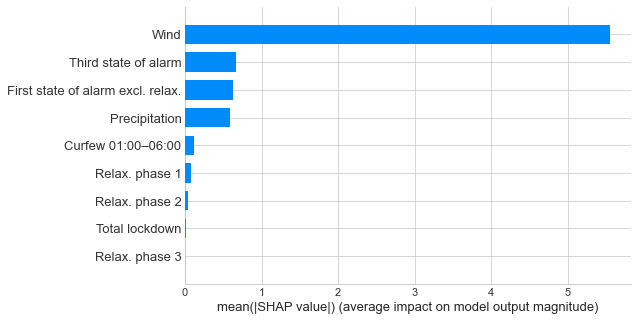

In [226]:
import shap

explainer = shap.TreeExplainer(rf_cv.best_estimator_)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, plot_type="bar")


We can see that the most important features are the wind speeds at 10m, the third state of alarm, and the first state of alarm. Other variables such as the relaxation phases and the total lockdown did not have any impact in the model

## 4. Genre

We used a Magazine Styled  genre with interactive and dynamic plots and graphs. We think this is the right format because the data is complex and contains a lot of dimensions, in addition to the fact that it needs to be controlled for different variables that influence it and it requires a deep analysis to connect the different lockdown measures with the data itself. A magazine style narrative with annotated charts seemed like the best format to convey the results of such complex analysis while providing proof of such conclusions. At the same time, the interactivity in those charts helps the reader explore and understand the data in a more elaborate way.  

In Visual Structuring we used progress bar/timebar to understand the beginnings and endings of the different phases of the easing of restrictions. In Highlighting we used zooming to navigate through the maps and graphs and investigate specific weeks or days; we also used motion with the maps to move through the maps and check the location of the analyzed stations. Finally in Transition Guidance we didn’t use any specific category because of our magazine style format. We used a “scroll down” Transition Guidance.  

In Narrative Structuring we used a linear Ordering, trying to follow a complexity line where we start with an introduction, some background information, a general yearly analyze, a weekly evolution, a clarification about the restrictions and timings during the pandemic, a combining pollution data and lockdown timings map and finally a correlation heatmap of the different factors involved. We also used Interactivity in the form of navigation buttons, filtering/selection maps and highlighting/details features. Finally in Messaging we used caption/headlines, accompanying article, introductory text and summary/synthesis. As we used a Magazine Styled genre, the narrative Structure came already really structured.

## 5. Visualizations

The specific visualization are explained both in the article and in the Data Analysis section.

We have chosen the visualization that, in our opinion, added more value to the whole picture. We made a big emphasis on creating visualization that were interactive, so that the reader can also explore the data with us. Therefore, almost all visualizations were done with Plotly.

We think they are right for the story we chose because they direct the reader towards the specific plots and trends, but they also allow for the reader to explore the data further. We have chosen a map to show the location of stations to position the reader and create a sort of mental map of what we are talking about. The time series show very relevant information when it comes to the evolution of pollution, as well as the difference between and after the lockdowns.

We have always worked with the average values because that is the data that international organizations take into account to create standards and limits, such as the WHO and the EU.

## 6. Discussion

We managed to do the project and include very interesting visualizations and analysis. We did all of that in an interactive way by building plotly plots and very clear charts that contain annotations and added information. We tried to find the most relevant restrictions when it came to reducing the pollution levels, which we partially achieved to do.  

On the improvement side, we believe that:

- We could have done a more rigorous analysis by having a bigger dataset (not only from 2019) and more variables, especifically mobility data. Right now in our analysis we variables that are far appart, meaning that we are trying to see the effect in pollution caused by the lockdown restrictions, while the connecting piece between the two is mobility data that we could not find. This would have improved the model performance as well.

- We struggled to find an algorithm that helps finding the importance of specific events in the time series. We though about using PCA, time series analysis, or causal inference but all of them were far away from the scope of this course, therefore we ended up using a random forest and interpreting its results, which we believe is a bit weak.


## Contributions

**Daniel Ansia Dibuja**: Researched on the topic and information, planned, facilitated and attended all team meetings (7), created a joint notebook environment, created video slides, script and structure, attended PAA class and gathered input, recorded half of the video and did video editting, plotted examples of visualizations presented in PAA, created and populated the website, performed modelling, built plotly plots, worked on data analysis, wrote the article, generated the regulations dataset, cleaned and pre-processed the air pollution dataset, consolidated and prepared the final notebook.

**Eduard Seguí Solé**: Researched on the topic and information, attended all team meetings, performed exploratory data analysis, attended PAA class and gathered input, wrote script and recorded half of PAA, plotted examples of visualizations presented in PAA, created initial visualizations and exploratory data analysis, gathered and pre-processed the meteorological data and the air pollution data, found relevant restrictions and events, wrote the article, helped consolidate and prepare the final notebook.

**Zhijian Feng**: attended 2 out of 7 team meetings, performed exploratory data analysis (of air pollution based on geographical location), found relevant restrictions and information, built a heatmap video.

## References


- [Air Quality in Europe 2020 Report, European Environmental Agency](https://www.eea.europa.eu/publications/air-quality-in-europe-2020-report)  
- [Air Quality Status Briefing 2021, European Environmental Agency](https://www.eea.europa.eu/publications/air-quality-in-europe-2021/air-quality-status-briefing-2021)  
- [Nitrogen Dioxide, American Lung Association](https://www.lung.org/clean-air/outdoors/what-makes-air-unhealthy/nitrogen-dioxide)  
- [Analysis of air pollution in Barcelona, Eldiario.es (spanish)](https://www.eldiario.es/catalunya/barcelona/radiografia-contaminacion-barcelona-infringiendo-ue_1_1186806.html)  
- [Ambient Air Pollution, World Health Organisation](https://www.who.int/news-room/fact-sheets/detail/ambient-(outdoor)-air-quality-and-health)  


**Data sources:**

- Air Quality: Obtained from the [City Council of Barcelona](https://opendata-ajuntament.barcelona.cat/data/ca/dataset/contaminants-estacions-mesura-qualitat-aire/resource/c122329d-d26d-469e-bf9e-8efa10e4c127).
- Meteorological Data: obtained from [Meteo.cat](https://www.meteo.cat).
- Regulatory Data: self-obtained from the Spanish and Catalan Official Journals.